In [5]:
from numpy import *
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import *
from scipy.stats import *
from scipy.optimize import leastsq
import numpy.random as random

# Determination constants $D_i$  from simulated data
In this notebook, a model to simulate data is applied to create datasets. On each dataset, 
a nonlinear regression is applied to find the constants $D_i$ for that specific dataset. 
Finally, the average of each $D_i$ is taken to give the final set of constants. 
- 1. Simulation of data
- 2. Extraction of constants and application for prediction: only mod. of elast. simulated.
- 3. Extraction of constants and application for prediction: all variables simulated.

In [6]:
# Gathering data and definition of functions to predict strength and to simulate data. 
data = read_csv('Data_MOBETa.csv',sep=';')
species = ['Billinga','Tali','Eveuss','Okan','Massaranduba','Greenheart']

random.seed(10)

for i in species: 
    nmetKR = len(data.KR[(data.KR>0)&(data.Species==i)])
    a = data.KR[(data.KR==0)&(data.Species==i)]
    remove_n = len(a) - nmetKR
    drop_indices = random.choice(data.index[(data.KR==0)&(data.Species==i)], remove_n, replace=False)
    data = data.drop(drop_indices)

def MOEaKRX(rho,a,KR,C2,C4,C6,vM,X1):
    MOE = ( (rho*C2 + X1*vM*rho*C2) * (1 - C6*KR) )  /  ( (C4-1)*np.sin(a)**2 + 1 )
    return MOE

def faKRX(rho,KR,MOEaKR,C1,C2,C3,C4,C5,C6,C7,r,vF,vM,X1,X2):
    f = ( rho*C1*( 1 + r*X1*vF + X2*vF*np.sqrt(1-r**2) )*( 1-C5*KR ) / \
                    ( (C3-1)*(rho*C2*(1+X1*vM)*(1-C6*KR)/MOEaKR - 1)*(1/(C4-1)) +1 ) ) +C7
    return f

def faKRX2(rho,a,KR,C1,C3,C5,C7,r,vF,X1,X2):
    f = ( rho*C1*( 1 + r*X1*vF + X2*vF*np.sqrt(1-r**2) )*( 1-C5*KR ) / \
                    ( (C3-1)*sin(a)**2 + 1) ) + C7
    return f

def faKRmod(rho,KR,MOEaKR,D1,D2,D3,D4,D5):
    f = (( rho*MOEaKR*(1-D3*KR) ) / ( D1*rho*(1-D4*KR) + D2*MOEaKR )) + D5
    return f

def errormod(rho,KR,MOE,D1,D2,D3,D4,X1,X2,vF,vM):
    error = (X2*vF*sqrt(1-r**2) * (1-D3*KR)*rho*MOE ) / (D1*rho*(1-D4*KR) + D2*MOE)
    return error

## 1. Simulation of data

In [7]:
# Setting constants for data simulation
X1=np.random.standard_normal(len(data.rho12))
X2=np.random.standard_normal(len(data.rho12))
for i in range(len(X1)):
    while (X1[i]<-2) | (X1[i]>2):
        X1[i] = np.random.standard_normal(1)
for i in range(len(X2)):
    while (X2[i]<-2) | (X2[i]>2):
        X2[i] = np.random.standard_normal(1)

vF = 0.15
vM = 0.09
r2 = 0.18
r = np.sqrt(r2)
C1 = 0.12
C2 = 27.
C3 = 30.
C4 = 14.
C5 = 1.05
C6 = 0.4
C7 = 5.
D1 = ( (C3-1)*C2 ) / ( C1*(C4-1) )
D2 = (C4-C3) / ( C1*(C4-1) )
D3 = C5
D4 = C6
D5 = C7

D:\Programs\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
D:\Programs\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


1.3891406102907935 -0.0612894877114826 0.8704155160659659 1.160124681595451e-05 0.2099912098477848
vM en vF zijn 0.241601266989651 0.3855838105804141 en R2 is 0.7576231706083817
-0.16158614192532278


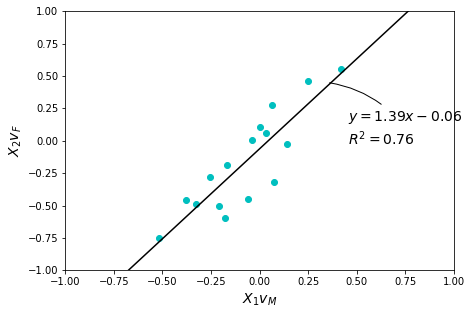

In [8]:
# Determination of factors vM and vF that are needed for simulating the randomness in the simulated data
data.X2vF = (data.fm12-C7) / (data.rho12*C1) - 1.
data.X1vM = (data.Edyn12) / (C2*data.rho12) - 1.
x = data.X1vM[(data.alpha==0.)&(data.KR==0.)]
y = data.X2vF[(data.alpha==0.)&(data.KR==0.)]

slope, intercept, r_value, p_value, std_err = linregress(x,y)
print (slope,intercept,r_value, p_value, std_err)
vF,vM,r = y.std(),x.std(),r_value
print ('vM en vF zijn',vM,vF,"en R2 is",r**2)
print (y.mean())

fig = plt.figure()
ax = fig.add_axes([0.05,0.05,0.9,0.9])
ax.set_xlim(-1,1)
ax.set_xlabel('$X_1 v_M$')
ax.xaxis.label.set_fontsize(14)
ax.set_ylim(-1,1)
ax.set_ylabel('$X_2 v_F$')
ax.yaxis.label.set_fontsize(14)
s = ax.scatter(x,y,color='c')
reeks = np.linspace(-1,1,100)
s2 = plt.plot(reeks,slope*reeks+intercept, 'k')
annotation_string = r"""$y=1.39x -0.06$
$R^2=0.76$"""
plt.annotate(annotation_string,
             xy=(0.35,0.45), xycoords='data',
             xytext=(20,-60), textcoords='offset points', fontsize=14,
             arrowprops=dict(arrowstyle="-", connectionstyle="arc3,rad=.2"))
# plt.savefig('x2vmx1vf'+'.eps', bbox_inches='tight')
plt.show()

0.8701106474736793 912.9378312754488 0.5807465811114513 2.279993840801135e-27 0.07212307533354731


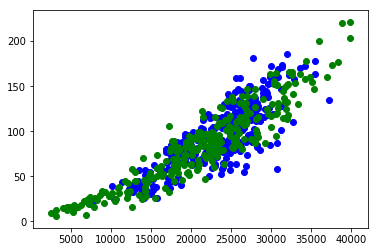

In [9]:
# Comparison of measured and simulated strength and modulus of elasticity
MOEaKR = MOEaKRX(data.rho12,data.alpha,data.KR,C2,C4,C6,vM,X1)
x = faKRX(data.rho12,data.KR,MOEaKR,C1,C2,C3,C4,C5,C6,C7,r,vF,vM,X1,X2)
# y = faKRX2(data.rho12,data.alpha,data.KR,C1,C3,C5,C7,r,vF,X1,X2)
# plt.scatter(x,y)
plt.figure()
plt.scatter(data.Edyn12,data.fm12,color='b')
plt.scatter(MOEaKR,x,color='g')
a,b,c,d,e = linregress(data.Edyn12,MOEaKR)
print (a,b,c,d,e)

## 2. Extraction of constants and application for prediction: only mod. of elast. simulated.

In [10]:
# Simulation of data and extraction of the set of constants D_i for each simulated dataset
# Simulation here is based on simulated values of mod. of elast. KR, grain angle and density are measured values.
def residuals(D,f,rho,KR,MOE):
    D1,D2,D3,D4,D5 = D
    err = f - ((( rho*MOE*(1-D3*KR) ) / ( D1*rho*(1-D4*KR) + D2*MOE )) + D5)
    return err

D0 = (D1,D2,D3,D4,D5)
D1list,D2list,D3list,D4list,D5list = [],[],[],[],[]
n = 100

for i in range(n):
    X1=np.random.standard_normal(len(data.rho12))
    X2=np.random.standard_normal(len(data.rho12))
    for i in range(len(X1)):
        while (X1[i]<-2) | (X1[i]>2):
            X1[i] = np.random.standard_normal(1)
    for i in range(len(X2)):
        while (X2[i]<-2) | (X2[i]>2):
            X2[i] = np.random.standard_normal(1)
    MOEsim = MOEaKRX(data.rho12,data.alpha,data.KR,C2,C4,C6,vM,X1)
    fsim = faKRX(data.rho12,data.KR,MOEsim,C1,C2,C3,C4,C5,C6,C7,r,vF,vM,X1,X2)
    Dlsq = leastsq(residuals, D0, args=(fsim,data.rho12,data.KR,MOEsim))
    D1list.append(Dlsq[0][0])
    D2list.append(Dlsq[0][1])
    D3list.append(Dlsq[0][2])
    D4list.append(Dlsq[0][3])
    D5list.append(Dlsq[0][4])
D1list = np.array(D1list)
D2list = np.array(D2list)
D3list = np.array(D3list)
D4list = np.array(D4list)
D5list = np.array(D5list)

In [18]:
# Taking the average of each constant D_i
print (mean(D1list),mean(D2list),mean(D3list),mean(D4list),mean(D5list))
print (std(D1list),std(D2list),std(D3list),std(D4list),std(D5list))
D1mean = mean(D1list)
D2mean = mean(D2list)
D3mean = mean(D3list)
D4mean = mean(D4list)
D5mean = mean(D5list)

402.9923669390792 -5.946970099471425 0.8763765075860792 0.2553284911975642 1.3405728637038883
22.874455080497867 0.8384664852323246 0.23438824800635888 0.2913514584499368 1.2018662076964253


a= 1.041766831458611 b= -3.927418058638679 r2= 0.6787603450390552 1.7115001807857895e-72 0.04237833149944803


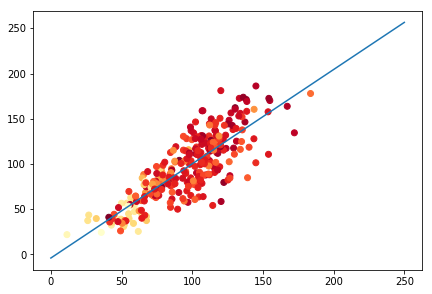

In [12]:
# Strength prediction of timber with the newly found constants D_i
fmod = faKRmod(data.rho12,data.KR,data.Edyn12,D1mean,D2mean,D3mean,D4mean,D5mean)

slope, intercept, r_value, p_value, std_err = linregress(fmod,data.fm12)
print ('a=',slope,'b=',intercept,'r2=',r_value**2, p_value, std_err)

fig = plt.figure()
ax = fig.add_axes([0.05,0.05,0.9,0.9])
s = ax.scatter(fmod,data.fm12,c=data.rho12,cmap='YlOrRd',edgecolor='face')
x = linspace(0,250,100)
y = x*slope + intercept
s2 = ax.plot(x,y)
plt.show()

## 3. Extraction of constants and application for prediction: all variables simulated.

In [13]:
# Below, all variables are simulated, including KR, grain angle and density. 
paramalpha = []
for i in species:
    X = data.alpha[(data.alpha!=0.) & (data.Species==i)]
    param_lognorm = lognorm.fit(X,1,loc=0) 
    paramalpha.append(param_lognorm)

paramKR = []
for i in species:
    X = data.KR[(data.KR!=0.) & (data.Species==i)]
    param_lognorm = lognorm.fit(X,1,loc=0)
    paramKR.append(param_lognorm)

In [20]:
# Simulation of data per species, first the number of samples with and without grain angle and knot ratio
# second, the size of the simulated graing angle and knot ratio

D1list, D2list, D3list, D4list, D5list = [], [], [], [], []
for m in range(n):
    
    ## Knot ratio and grain angle deviation present or not
    Pgeenalpha = zeros(len(species))
    PgeenKR = zeros(len(species))
    nspecies = zeros(len(species))
    for i in range(len(species)):
        Pgeenalpha[i] = len(data.alpha[(data.Species==species[i]) & (data.alpha==0)])  / float(len(data.alpha[data.Species==species[i]]))
        PgeenKR[i] = len(data.KR[(data.Species==species[i]) & (data.KR==0)])  / float(len(data.KR[data.Species==species[i]]))
        nspecies[i] = len(data.alpha[data.Species==species[i]])

    ## Grain angle or not
    a = []
    for i in range(len(species)):
        for j in range(len(data.alpha[data.Species==species[i]])):
            a.append(binom.rvs(1, 1-Pgeenalpha[i], loc=0, size=None))

    ### in case of grain angle: magnitude of deviation
    for i in range(len(a)):
        for j in range(len(species)):
            if a[i]==1:
                a[i] = lognorm.rvs(paramalpha[j][0],paramalpha[j][1],paramalpha[j][2],size=None)

    ## knots or not
    KR = []
    for i in range(len(species)):
        for j in range(len(data.KR[data.Species==species[i]])):
            KR.append(binom.rvs(1, 1-PgeenKR[i], loc=0, size=None))

    ### in case of knots: magnitude of knot ratio
    for i in range(len(KR)):
        for j in range(len(species)):
            if KR[i]==1:
                KR[i] = lognorm.rvs(paramKR[j][0],paramKR[j][1],paramKR[j][2],size=None)

    for i in range(len(KR)):
        if KR[i]>0.8:
            KR[i]=0.8

    KRsim = array(KR)
    alphasim = array(a)

    X1=np.random.standard_normal(len(data.rho12))
    X2=np.random.standard_normal(len(data.rho12))
    for i in range(len(X1)):
        while (X1[i]<-2) | (X1[i]>2):
            X1[i] = np.random.standard_normal(1)
    for i in range(len(X2)):
        while (X2[i]<-2) | (X2[i]>2):
            X2[i] = np.random.standard_normal(1)
            
    MOEsim = MOEaKRX(data.rho12,alphasim,KRsim,C2,C4,C6,vM,X1)
    fsim = faKRX(data.rho12,KRsim,MOEsim,C1,C2,C3,C4,C5,C6,C7,r,vF,vM,X1,X2)
    Dlsq = leastsq(residuals, D0, args=(fsim,data.rho12,KRsim,MOEsim))
    
    D1list.append(Dlsq[0][0])
    D2list.append(Dlsq[0][1])
    D3list.append(Dlsq[0][2])
    D4list.append(Dlsq[0][3])
    D5list.append(Dlsq[0][4])
D1list = np.array(D1list)
D2list = np.array(D2list)
D3list = np.array(D3list)
D4list = np.array(D4list)
D5list = np.array(D5list)

In [15]:
print (Pgeenalpha,PgeenKR)
for i in range(len(species)):
    print (species[i], len(data.alpha[data.Species==species[i]]),1-Pgeenalpha[i],len(data.KR[data.Species==species[i]]),1-PgeenKR[i])
print (len(data.alpha))

[0.11538462 0.16666667 0.02083333 0.17391304 0.07142857 0.1       ] [0.5 0.5 0.5 0.5 0.5 0.5]
Billinga 26 0.8846153846153846 26 0.5
Tali 24 0.8333333333333334 24 0.5
Eveuss 48 0.9791666666666666 48 0.5
Okan 46 0.8260869565217391 46 0.5
Massaranduba 84 0.9285714285714286 84 0.5
Greenheart 60 0.9 60 0.5
288


402.9923669390792 -5.946970099471425 0.8763765075860792 0.2553284911975642 1.3405728637038883
22.874455080497867 0.8384664852323246 0.23438824800635888 0.2913514584499368 1.2018662076964253


(array([ 2.,  8., 11., 15., 17., 11., 20., 11.,  2.,  3.]),
 array([-1.38108455, -0.81731763, -0.25355072,  0.31021619,  0.8739831 ,
         1.43775001,  2.00151692,  2.56528384,  3.12905075,  3.69281766,
         4.25658457]),
 <a list of 10 Patch objects>)

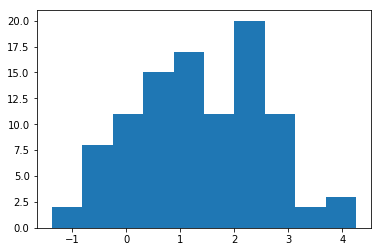

In [16]:
print (mean(D1list),mean(D2list),mean(D3list),mean(D4list),mean(D5list))
print (std(D1list),std(D2list),std(D3list),std(D4list),std(D5list))
D1mean = mean(D1list)
D2mean = mean(D2list)
D3mean = mean(D3list)
D4mean = mean(D4list)
D5mean = mean(D5list)

a= 1.0042001309867876 b= 4.252784849912288 r2= 0.6613493515313309 3.2878841700148437e-69 0.04249107776359336


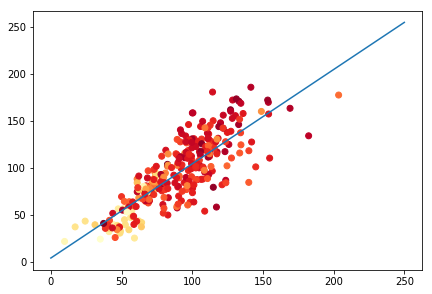

In [17]:
## Prediction of strength with all variables simulated
fmod = faKRmod(data.rho12,data.KR,data.Edyn12,D1mean,D2mean,D3mean,D4mean,D5mean)

slope, intercept, r_value, p_value, std_err = linregress(fmod,data.fm12)
print ('a=',slope,'b=',intercept,'r2=',r_value**2, p_value, std_err)

fig = plt.figure()
ax = fig.add_axes([0.05,0.05,0.9,0.9])
s = ax.scatter(fmod,data.fm12,c=data.rho12,cmap='YlOrRd',edgecolor='face')
x = linspace(0,250,100)
y = x*slope + intercept
s2 = ax.plot(x,y)
plt.show()